# Comparing various methods for Monument Colorization

\- *Aditya Arora*  *adityadvlp@gmail.com*

This notebook aims to investigates into the colorization problem which converts a grayscale image to a colorful version.
We use the pisaDataset (that contains sufficient color images) to attain a reliable solution to the colorization problem. We compare various models and hence present the results in terms of `mean squared error` as a metrics.

As a comparison to older methods, we chose the problem to check whether the models are able to color the original images of monuments which date a long back, around the 19th century when it was only possible to take black and white images.

In [1]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


2.2.0
1.9.0


## Part 1: Making the dataset

We have used the pisaDataset [avaliable here](http://www.nmis.isti.cnr.it/falchi/pisaDataset/). We run the following script to download all the images inot a *pisadatset/* directory. Alternatively, we can skip this, download the dataset from [google drive](https://drive.google.com/open?id=11Rp1xg2HPsCoI35UixL6dT0j4oVdBiCK), and jump to part 2.

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import cv2
import numpy as np
import os

In [3]:
import pandas as pd

from IPython.display import display, Image
from matplotlib.pyplot import imshow
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import Model

In [4]:
from keras.layers import Activation, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave,imshow,imread
import numpy as np
import random
import tensorflow as tf

In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Reshape, merge, concatenate

In [6]:
basepath='pisaDataset/'
# function that makes a directory if not already present
def makeFolder(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
#NOTE: Only run if dataset not downloaded
from urllib.request import urlopen
from urllib.parse import urlparse
from posixpath import basename
import re

# function that prcesses url, if there are any spaces it replaces with '%20'
def process_url(raw_url):
    return raw_url[:-1].replace(' ','%20') if ' ' in raw_url[-1] else raw_url.replace(' ','%20')
 
# function that grabs a url and copies all ianmges present on it to a directory
def grab(url,directory):
    baseurl='http://www.nmis.isti.cnr.it/falchi/pisaDataset/'
    url=baseurl+url
    urlcontent=urlopen(url).read()
    imgurls=re.findall('img .*?src="(.*?)"',urlcontent)
    for imgurl in imgurls:
        try:
            imgurl=process_url(imgurl)
            imgdata=urlopen(imgurl).read()
            filname=basename(urlsplit(imgurl)[2])
            output=open(directory+'/'+filname,'wb')
            output.write(imgdata)
            output.close()
        except:
            pass

urls=['Pisa-Basilica%20San%20Piero',
      'Pisa-Battistero',
      'Pisa-Campo%20Santo_Exterior',
      'Pisa-Campo%20Santo_Field',
      'Pisa-Campo%20Santo_Portico',
      'Pisa-Certosa',
      'Pisa-Chiesa%20della%20Spina',
      'Pisa-Duomo',
      'Pisa-Guelph%20Tower',
      'Pisa-Leaning%20Tower',
      'Pisa-Palazzo%20Carovana',
      'Pisa-Palazzo%20Orologio']

for i in range(len(urls)):
    makeFolder(basepath+str(i))
    grab(urls[i],basepath+str(i))


### Data Cleaning

When analyzed, we found that the datset is comparatively old and hence some of the images have already been unavailble. This in turn downloaded a  blank image containing a description of the unavailability of the image. We write a function to remove all unwanted images.

In [16]:
#NOTE: Only run if dataset not downloaded
def rem(directory):
    for f in glob(directory+'/*'):
        img=mpimg.imread(f)
        b = os.path.getsize(f)
        if len(img)>100 or b<500:
            os.remove(f)
for i in range(12):
    rem(basepath+str(i))

### Related Work

Many of the previous works done in image colorization tend to follow a Convolutional model or an encoder-decoder model. The dataset generally used is comparsatively huge and of higher dimensions. We tend to use a smaller dataset(7MB) and lower dimensions(75X75) to make the task challenging. This required us to use various techniques of data augmentation for increasing the dataset.

## Part 2: Data Augmentation

We can perform various kinds of data augmentation. There are also certain normalization techniques that should not be used based on the kind of task we are performing here. 
For instance, we should not use *featurewise_center* and *featurewise_std_normalization* as it helps in darkening and lightening of images.


In [35]:
makeFolder('images')
x=[]
for i in glob("pisaDataset/*/*.jpg"):
    im = imread(i)
    im = cv2.resize(im, (80,80)) 
    x.append(im)

In [36]:
x=np.array(x)

In [37]:
print(x.shape)

(983, 80, 80, 3)


C:\Users\gaurav\Anaconda2\envs\fnc\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


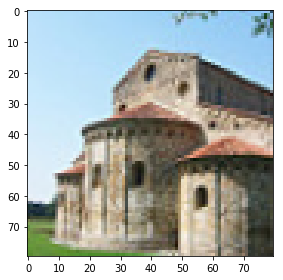

In [11]:
imshow(x[0])

In [38]:
x = x.astype('float32')

In [42]:
def save_augmentation(iterations):
    # Random Rotations
    datagen = ImageDataGenerator(rotation_range=90)
    # fit parameters from data
    datagen.fit(x)
    # configure batch size and retrieve one batch of images
    j=0
    for i in datagen.flow(x, save_to_dir='images',batch_size=9, save_prefix='aug', save_format='jpg'):
        j+=1
        if j==iterations:
            break

    # Random Shifts
    shift = 0.2
    datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
    # fit parameters from data
    datagen.fit(x)
    # configure batch size and retrieve one batch of images
    j=0
    for i in datagen.flow(x, save_to_dir='images',batch_size=9, save_prefix='aug', save_format='jpg'):
        j+=1
        if j==iterations:
            break

    # Random Flips
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    # fit parameters from data
    datagen.fit(x)
    # configure batch size and retrieve one batch of images
    j=0
    for i in datagen.flow(x, save_to_dir='images',batch_size=9, save_prefix='aug', save_format='jpg'):
        j+=1
        if j==iterations:
            break

In [43]:
save_augmentation(50)

## Part 3: Reading and processing Images

We use **the Lab color space** (lab) instead of RGB as it mathematically describes all perceivable colors in the three dimensions with L for **lightness**, and the color components a for **green–red** and b for **blue–yellow**.

Unlike the RGB color models, Lab color is designed to approximate **human vision**. Thus, it can be used to make accurate color balance corrections by modifying output curves in the a and b components, or to adjust the lightness contrast using the L component. This is the same reason why we did not use *featurewise_center* data augmentation.

In [7]:
x=[]
for i in glob("images/*.jpg"):
    im = imread(i)
    im = cv2.resize(im, (80,80)) 
    x.append(im)
x=np.array(x)
x = x.astype('float32')
print(x.shape)

(14607, 80, 80, 3)


In [8]:
# Set up train and test data
from sklearn.model_selection import train_test_split
Xtrain,Xtest=train_test_split(x,test_size=0.05,shuffle=True, random_state=1234)

Xtrain = 1.0/255*Xtrain
print(Xtrain.shape)
Xtest = 1.0/255*Xtest
print(Xtest.shape)

(13876, 80, 80, 3)
(731, 80, 80, 3)


In [10]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def generate_data(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

## Part 4: Defining models

We define various models, from a simple Convolution and UpSampling layers tousing Deconvolution layers.

In [11]:
#model1 can be used for learning single image features
def model1():
    inpx = Input(shape=(None, None, 1))
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(inpx)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    score = Conv2D(2, (3,3), activation='tanh', padding='same')(x)
    model = Model(inpx,score)
    # Finish model
    model.compile(optimizer='rmsprop', loss='mse')

    return model

#model2 uses higher dimensions convlution deconvolution layers
def model2(dimx,dimy,op='rmsprop'):
    inpx = Input(shape=(dimx, dimy, 1))
    x = Conv2D(8, (6, 6), activation='relu', padding='same', strides=2)(inpx)

    x = Conv2D(16, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(16, (6, 6), activation='relu', padding='same', strides=2)(x)

    x = Conv2D(32, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(32, (6, 6), activation='relu', padding='same', strides=2)(x)

    x = Conv2D(64, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(64, (6, 6), activation='relu', padding='same', strides=4)(x)

    x = Conv2D(128, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(128, (6, 6), activation='relu', padding='same', strides=4)(x)

    x= Conv2DTranspose(128,(4, 4), strides=4)(x)
    x= Conv2DTranspose(128,(4, 4))(x)

    x= Conv2DTranspose(64,(6, 6), strides=4)(x)
    x= Conv2DTranspose(64,(6, 6))(x)
    
    x= Conv2DTranspose(32,(6, 6))(x)
    
    x = Conv2D(32, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(16, (6, 6), activation='relu', padding='same')(x)
    x = Conv2D(2,  (6, 6), activation='tanh', padding='same')(x)
    score = UpSampling2D((2, 2))(x)

    model = Model(inpx,score)
    # Finish model
    model.compile(optimizer=op, loss='mse')
    return model

#model3 can be used for learning single image features
def model3(dimx,dimy,op='rmsprop'):
    inpx = Input(shape=(dimx, dimy, 1))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inpx)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)
    score = UpSampling2D((2, 2))(x)
    
    model = Model(inpx,score)
    model.compile(optimizer=op, loss='mse')
    return model


In [34]:
model=model3(Xtrain.shape[1],Xtrain.shape[2],'adam')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 80, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 80, 80, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 20, 128)       147584    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 20, 20, 256)       295168    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 256)       590080    
__________

In [36]:
# Train model  
makeFolder('result')
tensorboard = TensorBoard(log_dir="output/beta_run")
model.fit_generator(generate_data(batch_size), callbacks=[tensorboard], epochs=1000, steps_per_epoch=1)

Epoch 1/1000
1/1 [==============================] - 0s 263ms/step - loss: 0.0268
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.0000
Epoch 3/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.0223
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.0363
Epoch 5/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.9999
Epoch 6/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.9273
Epoch 7/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.9725
Epoch 8/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.9802
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 10/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 11/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0160
Epoch 12/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0121
Epoch 13/1000
1/1 [=====================

Epoch 103/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 104/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0113
Epoch 105/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0159
Epoch 106/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0083
Epoch 107/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0082
Epoch 108/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0128
Epoch 109/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0120
Epoch 110/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0076
Epoch 111/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0079
Epoch 112/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0179
Epoch 113/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0103
Epoch 114/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0255
Epoch 115/1000
1

1/1 [==============================] - 0s 22ms/step - loss: 0.0081
Epoch 204/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0100
Epoch 205/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0163
Epoch 206/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0137
Epoch 207/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0170
Epoch 208/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0122
Epoch 209/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0055
Epoch 210/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0079
Epoch 211/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0043
Epoch 212/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0088
Epoch 213/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0063
Epoch 214/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0108
Epoch 215/1000
1/1 [===========

Epoch 304/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0085
Epoch 305/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0093
Epoch 306/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0100
Epoch 307/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0114
Epoch 308/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 309/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0138
Epoch 310/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0060
Epoch 311/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0091
Epoch 312/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0117
Epoch 313/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0076
Epoch 314/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0045
Epoch 315/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 316/1000
1

1/1 [==============================] - 0s 42ms/step - loss: 0.0111
Epoch 405/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0064
Epoch 406/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0053
Epoch 407/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 408/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0059
Epoch 409/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0071
Epoch 410/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 411/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0100
Epoch 412/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0103
Epoch 413/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0059
Epoch 414/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0069
Epoch 415/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 416/1000
1/1 [=============

Epoch 505/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0075
Epoch 506/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0066
Epoch 507/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0049
Epoch 508/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0068
Epoch 509/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0044
Epoch 510/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.0057
Epoch 511/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0064
Epoch 512/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0108
Epoch 513/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0051
Epoch 514/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 515/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0065
Epoch 516/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0069
Epoch 517/1000
1/

1/1 [==============================] - 0s 44ms/step - loss: 0.0167
Epoch 606/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0057
Epoch 607/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0055
Epoch 608/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0038
Epoch 609/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0034
Epoch 610/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0094
Epoch 611/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0093
Epoch 612/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0144
Epoch 613/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0075
Epoch 614/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0074
Epoch 615/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0036
Epoch 616/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0062
Epoch 617/1000
1/1 [===========

Epoch 706/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0054
Epoch 707/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0074
Epoch 708/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0041
Epoch 709/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 710/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0046
Epoch 711/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0089
Epoch 712/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0066
Epoch 713/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0058
Epoch 714/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0066
Epoch 715/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0061
Epoch 716/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0059
Epoch 717/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0050
Epoch 718/1000
1/

Epoch 807/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0073
Epoch 808/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 809/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0084
Epoch 810/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0158
Epoch 811/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0092
Epoch 812/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0059
Epoch 813/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 814/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0064
Epoch 815/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0040
Epoch 816/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0084
Epoch 817/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 818/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0055
Epoch 819/1000
1/1

1/1 [==============================] - 0s 36ms/step - loss: 0.0140
Epoch 908/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0064
Epoch 909/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0113
Epoch 910/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0071
Epoch 911/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0056
Epoch 912/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0063
Epoch 913/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0094
Epoch 914/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0100
Epoch 915/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0067
Epoch 916/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0090
Epoch 917/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 918/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0067
Epoch 919/1000
1/1 [===========

In [37]:
# Test images
Xtest=rgb2lab(Xtest)
xt=Xtest[:,:,:,0]
xt=xt.reshape(xt.shape+(1,))

yt=Xtest[:,:,:,1:]
yt=yt / 128

print(xt.shape)
print(yt.shape)

(731, 80, 80, 1)
(731, 80, 80, 2)


In [38]:
model.evaluate(xt, yt, batch_size=batch_size)

731/731 [==============================] - 0s 636us/step


9218.486770984739

In [39]:
t=[]
for i in glob("test_images/*.jpg"):
    im = cv2.imread(i)
    im = cv2.resize(im, (80,80)) 
    t.append(im)
    
t=np.array(t)
color_me = t.astype('float32')

In [40]:
print("Found {} images!".format(len(color_me)))

Found 7 images!


In [41]:
color_me = np.array(color_me)
print(color_me.shape)

(7, 80, 80, 3)


In [42]:
color_me = color_me.astype('float32')
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [43]:
# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((80, 80, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".jpg", lab2rgb(cur))

C:\Users\USER 1\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Part 4: Problems that occured during the task

We have to make sure that we don't use `cv2` for image reading as it reads the image in `BGR` format and all other functions we call such as `rgb2lab` use the `RGB` format. This would result in wromg image data. We have tested on runin the `model1` on `epochs=1`. We found that the model learns only a single color, but, in case of cv2 the color was wrong as well. 

### Results using original dataset and runtime augmentation

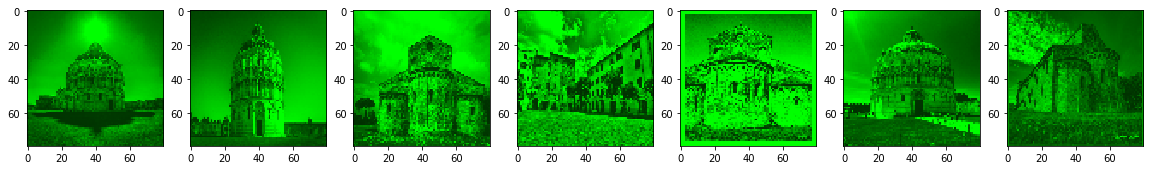

In [8]:
#cv2
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
# We used cv2.imread while training and saved the results. We use imread here to correctly display the image here.
for f in glob('impl_results/result0/*.png'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

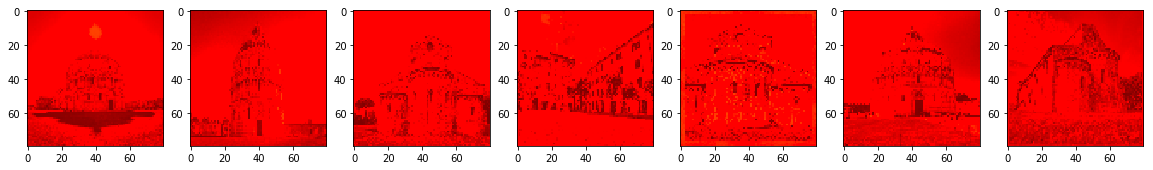

In [9]:
#skimage
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result1/*.png'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

We get a band of colors when run on `epochs=30` which made us realized that we need to run the model for many epochs.

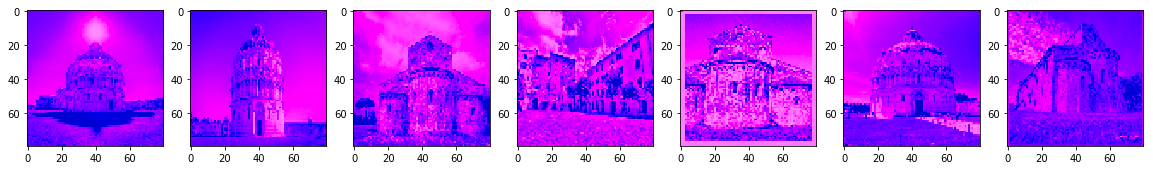

In [10]:
#less epochs
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result2/*.png'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Results using augmented dataset and runtime augmentation

Even when we increased the epochs to 100, we still did not get satisfactory results. This made us realize that we need to increase the dataset more and at the same time, run on different optimizers and many eopchs.

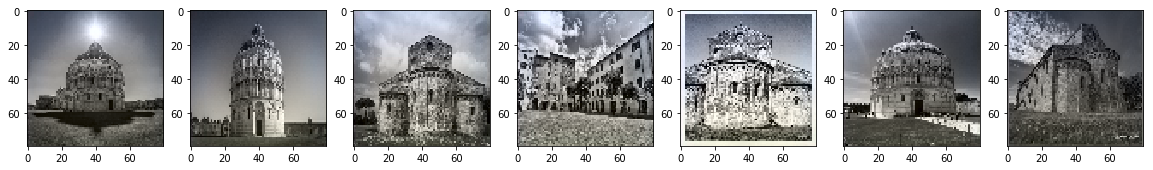

In [12]:
#100 epochs
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result3/*.png'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Part 5: Showing results on a BW images

We downloaded originally grayscale images from google images and put them in `test_images` folder.

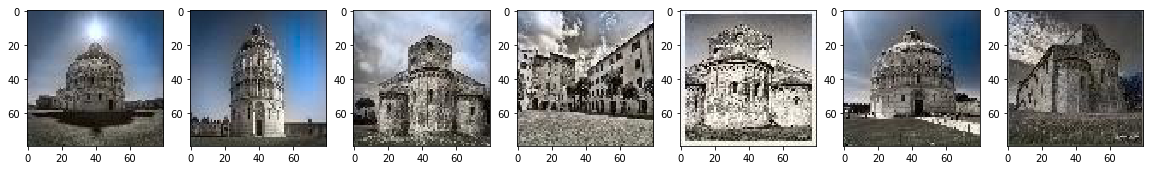

In [22]:
#adam model3
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result7/*.jpg'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

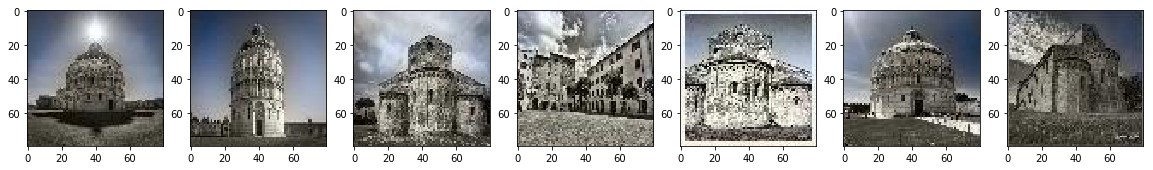

In [33]:
#adadelta model3
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result8/*.jpg'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

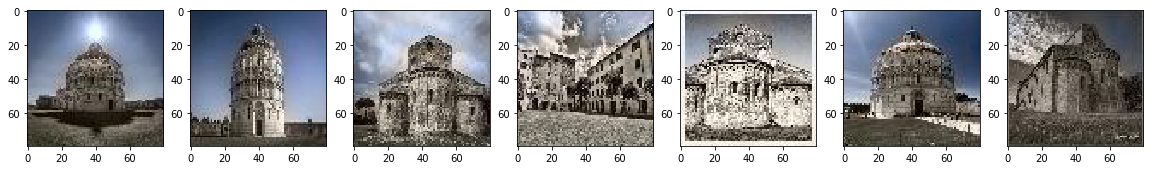

In [44]:
#rmsprop model3
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result9/*.jpg'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

We get the best results on running the model on `epochs=1000`, `optimizer=adam` and ruunning on augmented data as well as runtime augmentation.

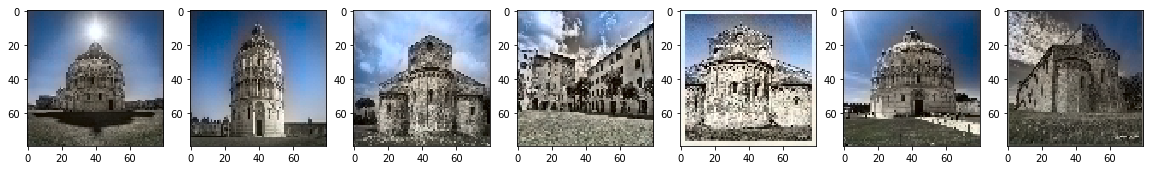

In [16]:
#1000 epochs
fig=plt.figure(figsize=(20, 20))
columns = 7
rows = 1
i=0
for f in glob('impl_results/result4/*.png'):
    i+=1
    img=imread(f)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Future Scope

We can run this on a pretrained models such as `InceptionResNetV2` and on a bigger dataset to get better results.